In [4]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.mask import mask
import matplotlib.pyplot as plt
from shapely.geometry import Point, box
import tarfile
from plotnine import *
from sklearn.preprocessing import StandardScaler

In [24]:
import requests
import pandas as pd


API_KEY = ''


base_url = 'https://api.census.gov/data/2020/dec/pl'
params = {
    'get': 'P1_001N', # population
    'for': 'tract:*',
    'in': 'state:06',  # California state code is 06
    'key': API_KEY
}

response = requests.get(base_url, params=params)

if response.status_code == 200:
    data = response.json()
    california_df = pd.DataFrame(data[1:], columns=data[0])
else:
    print(f"Error: {response.status_code}")

if response.status_code != 200:
    print(f"Failed to retrieve data: {response.text}")


california_df = california_df.rename(columns={ 'P1_001N': 'population'})
california_df.head()

,population,state,county,tract
0,3038,06,001,400100
1,2001,06,001,400200
2,5504,06,001,400300
3,4112,06,001,400400
4,3644,06,001,400500


In [18]:
california_df.shape

(9129, 4)

In [19]:
california_tracts_shape = gpd.read_file('tl_2024_06_tract/tl_2024_06_tract.shp')
print(california_tracts_shape.shape)
california_tracts_shape.columns

(9129, 14)


Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'GEOIDFQ', 'NAME',
       'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT',
       'INTPTLON', 'geometry'],
      dtype='object')

In [61]:
# Merge the population data with the shapefile
california_df['GEOID'] = california_df['state'] + california_df['county'] + california_df['tract']
california_tract_df = california_tracts_shape.merge(california_df, on='GEOID', how='left')

california_tract_df = california_tract_df[['geometry', 'population', 'GEOID']]
# Convert to GeoDataFrame
california_gdf = gpd.GeoDataFrame(california_tract_df, geometry='geometry')
california_gdf = california_gdf.to_crs(epsg=3310)

california_gdf.head()

,geometry,population,GEOID
0,"POLYGON ((-177981.55 -51137.614, -177979.26 -5...",3141,06001442700
1,"POLYGON ((-176688.486 -52219.888, -176682.583 ...",2959,06001442800
2,"POLYGON ((165979.248 -442413.375, 165979.82 -4...",2537,06037204920
3,"POLYGON ((164414.225 -441707.563, 164427.648 -...",3850,06037205110
4,"POLYGON ((164371.473 -442343.081, 164374.645 -...",3858,06037205120


In [62]:
california_gdf.crs

<Projected CRS: EPSG:3310>
Name: NAD83 / California Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - California.
- bounds: (-124.45, 32.53, -114.12, 42.01)
Coordinate Operation:
- name: California Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

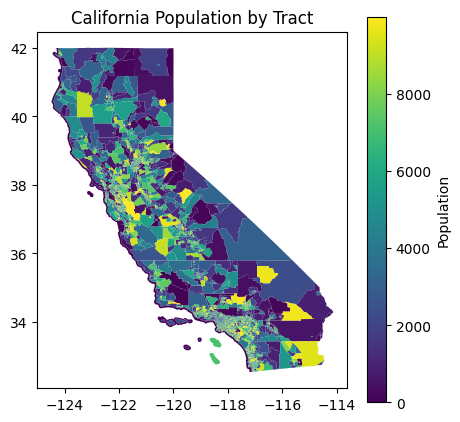

In [93]:
# Plotting the population data
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# california_tract_df.boundary.plot(ax=ax, linewidth=.1, color='black')
california_tract_df.plot(column='population', ax=ax, legend=False,
                          cmap='viridis')

# Add a color bar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=california_tract_df['population'].min(), vmax=california_tract_df['population'].max()))
sm._A = []
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Population')

plt.title('California Population by Tract')
plt.show()


In [56]:
state_shapes = gpd.read_file('cb_2017_us_state_500k/cb_2017_us_state_500k.shp')
california = state_shapes[state_shapes['STUSPS'] == 'CA']

print(california.columns)

Index(['STATEFP', 'STATENS', 'AFFGEOID', 'GEOID', 'STUSPS', 'NAME', 'LSAD',
       'ALAND', 'AWATER', 'geometry'],
      dtype='object')


In [32]:
from tqdm import tqdm
import os
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.windows import from_bounds
from shapely.geometry import Point
from tqdm import tqdm

def process_viirs_file_with_boundary(file_path, boundary_gdf):
    """
    Process a VIIRS nighttime lights file and extract only points within a specific boundary.

    Parameters:
    -----------
    file_path : str
        Path to the TIFF file.
    boundary_gdf : GeoDataFrame
        Geopandas dataframe containing the boundary (e.g., California).

    Returns:
    --------
    GeoDataFrame
        A GeoDataFrame containing nighttime light data within the specified boundary.
    """
    print(f"Processing file: {os.path.basename(file_path)}")

    boundary = boundary_gdf.unary_union

    # Read the TIFF file
    with rasterio.open(file_path) as src:
        # Ensure boundary CRS matches raster CRS
        if boundary_gdf.crs != src.crs:
            boundary_gdf = boundary_gdf.to_crs(src.crs)

        boundary_transformed = boundary_gdf.unary_union

        # Get bounds of the boundary in the raster's coordinate system
        minx, miny, maxx, maxy = boundary_transformed.bounds
        window = from_bounds(minx, miny, maxx, maxy, src.transform).round_lengths().round_offsets()

        # Read data within the window
        window_data = src.read(1, window=window)
        window_transform = rasterio.windows.transform(window, src.transform)

        # Handle nodata values
        nodata_val = src.nodata if src.nodata is not None else -999
        valid_mask = (window_data > nodata_val) & (window_data != nodata_val)

        # Get valid data points
        y_indices, x_indices = np.where(valid_mask)

        # Convert pixel coordinates to geographic coordinates
        print("Converting pixel coordinates to geographic coordinates...")
        xs, ys = rasterio.transform.xy(window_transform, y_indices, x_indices, offset='center')

        # Create GeoDataFrame with points
        print("Creating points and filtering by boundary...")
        points_gdf = gpd.GeoDataFrame(
            {'geometry': [Point(x, y) for x, y in tqdm(zip(xs, ys), total=len(xs))]},
            crs=src.crs
        )

        # Filter using spatial join for efficiency
        print("Performing spatial join...")
        points_in_boundary = gpd.sjoin(points_gdf, boundary_gdf, predicate="within", how="inner")

        # Get corresponding values
        indices_in_boundary = points_in_boundary.index
        values_in_boundary = window_data[y_indices[indices_in_boundary], x_indices[indices_in_boundary]]

        # Create final GeoDataFrame
        result_gdf = gpd.GeoDataFrame({
            'light_value': values_in_boundary,
            'geometry': points_in_boundary.geometry
        }, crs=src.crs)

        print(f"Extracted {len(result_gdf)} points within the boundary")
        return result_gdf


california_shapefile = california
light_density_df = process_viirs_file_with_boundary(
    "SVDNB_npp_20250101-20251231_75N180W_vcmcfg_v10_c202502181200/SVDNB_npp_20250101-20251231_75N180W_vcmcfg_v10_c202502181200.avg_rade9h.tif",
    california_shapefile
)

Processing file: SVDNB_npp_20250101-20251231_75N180W_vcmcfg_v10_c202502181200.avg_rade9h.tif


/var/folders/gr/mhlc8kfs39b7v4v54d1fd4bc0000gn/T/ipykernel_47224/2941308662.py:28: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
/var/folders/gr/mhlc8kfs39b7v4v54d1fd4bc0000gn/T/ipykernel_47224/2941308662.py:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.


Converting pixel coordinates to geographic coordinates...
Creating points and filtering by boundary...


100%|██████████| 5609958/5609958 [00:15<00:00, 360378.22it/s]


Performing spatial join...
Extracted 2400163 points within the boundary


In [57]:
print(light_density_df.shape)
light_density_df.head()


(2400163, 2)


,light_value,geometry
302,0.35,POINT (-123.15 42.00833)
303,0.30,POINT (-123.14583 42.00833)
304,0.28,POINT (-123.14167 42.00833)
305,0.36,POINT (-123.1375 42.00833)
306,0.33,POINT (-123.13333 42.00833)


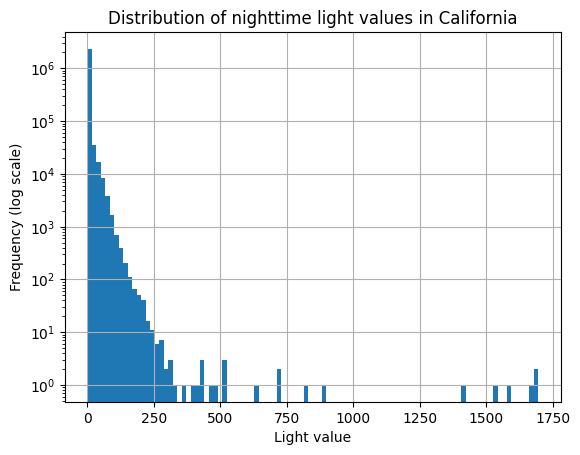

In [58]:
light_density_df['light_value'].hist(bins=100, log=True)
plt.xlabel("Light value")
plt.ylabel("Frequency (log scale)")
plt.title("Distribution of nighttime light values in California")

plt.show()

In [144]:
import geopandas as gpd
import numpy as np
from shapely.geometry import box
from tqdm import tqdm
from shapely.strtree import STRtree

def create_scalable_grid(gdf, cell_size=10):
    """
    Create a grid over polygons with customizable cell size for better scaling.
    
    Parameters:
    -----------
    gdf : GeoDataFrame
        The input geodataframe containing polygon geometries
    cell_size : float
        Size of each grid cell (larger values = fewer cells = faster processing)
        
    Returns:
    --------
    GeoDataFrame
        A geodataframe containing the grid cells
    """
    # Determine the overall bounds of all geometries
    total_bounds = gdf.total_bounds
    print(f"Total bounds: {total_bounds}")
    minx, miny, maxx, maxy = total_bounds
    print(f"Minx: {minx}, Miny: {miny}, Maxx: {maxx}, Maxy: {maxy}")
    
    # Create a grid across the entire area with larger cells
    x_coords = np.arange(np.floor(minx), np.ceil(maxx), cell_size)
    y_coords = np.arange(np.floor(miny), np.ceil(maxy), cell_size)
    
    print(f"Creating grid with cell size {cell_size}...")
    print(f"Grid dimensions: {len(x_coords)}x{len(y_coords)} = {len(x_coords)*len(y_coords)} cells")
    
    # Generate all possible grid cells as boxes
    grid_cells = []
    for x in tqdm(x_coords, desc="Creating grid cells"):
        for y in y_coords:
            cell = box(x, y, x + cell_size, y + cell_size)
            grid_cells.append(cell)
    
    # Create a spatial index for the input polygons
    print("Building spatial index...")
    spatial_index = STRtree([geom for geom in gdf.geometry])
    
    # For each grid cell, check if it intersects with any polygon
    valid_cells = []
    print(f"Filtering {len(grid_cells)} grid cells...")
    for cell in tqdm(grid_cells, desc="Filtering cells"):
        # Query the spatial index to find potential intersections
        potential_matches_idx = spatial_index.query(cell)
        
        # Check if the cell actually intersects with any of these polygons
        if any(gdf.geometry.iloc[idx].intersects(cell) for idx in potential_matches_idx):
            valid_cells.append(cell)
    
    # Convert to GeoDataFrame
    print(f"Creating final GeoDataFrame with {len(valid_cells)} cells...")
    grid_gdf = gpd.GeoDataFrame(geometry=valid_cells, crs=gdf.crs)
    
    # Add grid cell ID and area columns for analysis
    grid_gdf['cell_id'] = range(len(grid_gdf))
    grid_gdf['area'] = grid_gdf.area
    
    return grid_gdf

cell_size = 500  # Each grid cell is 500 meters by 500 meters
grid_gdf = create_scalable_grid(gdf=california_gdf, cell_size=cell_size)



Total bounds: [-380101.0656607  -605252.61217882  540037.54685041  450446.71159829]
Minx: -380101.06566070096, Miny: -605252.612178822, Maxx: 540037.5468504131, Maxy: 450446.71159829013
Creating grid with cell size 500...
Grid dimensions: 1841x2112 = 3888192 cells


Creating grid cells: 100%|██████████| 1841/1841 [00:28<00:00, 64.73it/s]


Building spatial index...
Filtering 3888192 grid cells...


Filtering cells: 100%|██████████| 3888192/3888192 [02:11<00:00, 29493.96it/s]


Creating final GeoDataFrame with 1701116 cells...


/var/folders/gr/mhlc8kfs39b7v4v54d1fd4bc0000gn/T/ipykernel_47224/534698081.py:10: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.


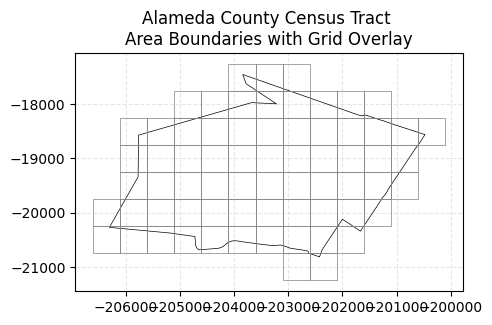

In [147]:
# plot grid lines in just one county 

fig, ax = plt.subplots(figsize=(5, 5))

# Filter the california_gdf for the specific county
san_mateo = california_gdf[california_gdf['GEOID'] == '06001401700']
san_mateo.boundary.plot(ax=ax, linewidth=0.5, label='County Boundary', color='black')

# Filter the grid_gdf for the specific county
san_mateo_grid = grid_gdf[grid_gdf.intersects(san_mateo.unary_union)]
san_mateo_grid.boundary.plot(ax=ax, linewidth=0.5, alpha=1, color='gray')

plt.title('Alameda County Census Tract \nArea Boundaries with Grid Overlay')
plt.xlabel('')
plt.ylabel('')

plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

In [150]:
grid_gdf.shape

(1701116, 3)

In [168]:
from sklearn.preprocessing import MinMaxScaler

light_density_df.reset_index(drop=True, inplace=True)
points_gdf = light_density_df.copy()
polygons_gdf = grid_gdf.copy()

# Ensure CRS match
points_gdf = points_gdf.to_crs(polygons_gdf.crs)

# Spatial join to find which points fall in which polygons
joined = gpd.sjoin(points_gdf, polygons_gdf, how="left", predicate="within")

# fill in the light value with 0 for the points that are not in the polygons
joined['light_value'] = joined['light_value'].fillna(0)

# # # Group by polygon and concatenate light values
result = joined.groupby("cell_id")["light_value"].sum().reset_index()

result.rename(columns={"light_value": "sum_light_value"}, inplace=True)

# # # Merge with polygon data to retain geometry
polygons_gdf = polygons_gdf.merge(result, on="cell_id", how="right")

# trnasform the light value to a range of 0 to 2 to act as a scaling factor
scaler = MinMaxScaler(feature_range=(0, 2))
polygons_gdf['scaling_factor'] = scaler.fit_transform(polygons_gdf['sum_light_value'].values.reshape(-1, 1))

polygons_gdf.head()


,geometry,cell_id,area,sum_light_value,scaling_factor
0,"POLYGON ((-373602 277247, -373602 277747, -374...",560,250000.0,0.27,0.000721
1,"POLYGON ((-373602 277747, -373602 278247, -374...",561,250000.0,0.21,0.000667
2,"POLYGON ((-373102 275747, -373102 276247, -373...",644,250000.0,0.36,0.000801
3,"POLYGON ((-373102 276247, -373102 276747, -373...",645,250000.0,0.29,0.000738
4,"POLYGON ((-373102 276747, -373102 277247, -373...",646,250000.0,0.26,0.000712


In [170]:
polygons_gdf.columns

Index(['geometry', 'cell_id', 'area', 'sum_light_value', 'scaling_factor'], dtype='object')

Text(0.5, 1.0, 'Scaling Factor Distribution by Grid in Water Boundaries')

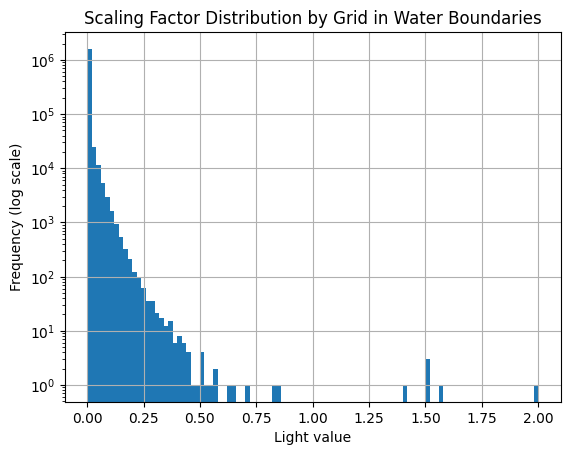

In [171]:
polygons_gdf['scaling_factor'].hist(bins=100, log=True)
plt.xlabel("Light value")
plt.ylabel("Frequency (log scale)")
plt.title("Scaling Factor Distribution by Grid in Water Boundaries")

In [172]:
california_gdf.head()

,geometry,population,GEOID,tract_area
0,"POLYGON ((-177981.55 -51137.614, -177979.26 -5...",3141,06001442700,1.234016e+06
1,"POLYGON ((-176688.486 -52219.888, -176682.583 ...",2959,06001442800,1.278647e+06
2,"POLYGON ((165979.248 -442413.375, 165979.82 -4...",2537,06037204920,9.099753e+05
3,"POLYGON ((164414.225 -441707.563, 164427.648 -...",3850,06037205110,2.869608e+05
4,"POLYGON ((164371.473 -442343.081, 164374.645 -...",3858,06037205120,1.466240e+06


In [114]:
# Ensure both dataframes are in the same CRS (likely EPSG:3310)
california_gdf = california_gdf.to_crs(epsg=3310)
polygons_gdf = polygons_gdf.to_crs(epsg=3310)

# Perform a spatial join to determine which grid cells are in which tracts
grid_with_tracts = gpd.sjoin(polygons_gdf, california_gdf, how='left', predicate='within')

# Check the result of the spatial join
grid_with_tracts

,geometry,cell_id,area,sum_light_value,scaling_factor,index_right,population,GEOID,tract_area
0,"POLYGON ((-370102 244747, -370102 254747, -380...",0,100000000.0,NaN,NaN,NaN,NaN,NaN,NaN
1,"POLYGON ((-370102 254747, -370102 264747, -380...",1,100000000.0,5.390000,0.000220,NaN,NaN,NaN,NaN
2,"POLYGON ((-370102 264747, -370102 274747, -380...",2,100000000.0,13.630000,0.000568,NaN,NaN,NaN,NaN
3,"POLYGON ((-370102 274747, -370102 284747, -380...",3,100000000.0,52.250000,0.002202,NaN,NaN,NaN,NaN
4,"POLYGON ((-370102 284747, -370102 294747, -380...",4,100000000.0,6.350000,0.000260,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
4494,"POLYGON ((529898 -385253, 529898 -375253, 5198...",4494,100000000.0,32.990002,0.001387,NaN,NaN,NaN,NaN
4495,"POLYGON ((539898 -415253, 539898 -405253, 5298...",4495,100000000.0,86.250000,0.003640,NaN,NaN,NaN,NaN
4496,"POLYGON ((539898 -405253, 539898 -395253, 5298...",4496,100000000.0,250.009995,0.010568,NaN,NaN,NaN,NaN
4497,"POLYGON ((539898 -395253, 539898 -385253, 5298...",4497,100000000.0,67.720001,0.002856,NaN,NaN,NaN,NaN


In [115]:
california_gdf.shape

(9129, 4)

In [174]:
# Make sure both dataframes are in the same CRS
polygons_gdf = polygons_gdf.to_crs(california_gdf.crs)

# Perform spatial intersection to determine which grid cells intersect with which census tracts
intersection = gpd.overlay(polygons_gdf, california_gdf, how='intersection')

# Calculate the area of each intersection
intersection['intersection_area'] = intersection.geometry.area

# Add the scaling factor information to the intersection
# This will be used to distribute population proportionally
intersection['weighted_area'] = intersection['intersection_area'] * intersection['scaling_factor']

# Calculate total weighted area per tract
tract_weighted_areas = intersection.groupby('GEOID')['weighted_area'].sum().reset_index()
tract_weighted_areas.rename(columns={'weighted_area': 'total_weighted_area'}, inplace=True)

# Merge back to get total weighted area for each tract
intersection = intersection.merge(tract_weighted_areas, on='GEOID', how='left')

# Calculate the proportion of population for each grid cell within a tract
# If total_weighted_area is 0, use the area proportion instead
intersection['population_proportion'] = intersection.apply(
    lambda row: row['weighted_area'] / row['total_weighted_area'] 
    if row['total_weighted_area'] > 0 
    else row['intersection_area'] / row['tract_area'], 
    axis=1
)

# Calculate the population for each grid cell
intersection['cell_population'] = intersection.apply(
    lambda row: row['population_proportion'] * float(row['population']), 
    axis=1
)
intersection['cell_population'] = intersection['cell_population'].round().astype(int)

# Group by cell_id to get total population for each grid cell
# (in case a grid cell intersects multiple tracts)
grid_population = intersection.groupby('cell_id')['cell_population'].sum().reset_index()

# Merge population data back to the original grid
polygons_gdf = polygons_gdf.merge(grid_population, on='cell_id', how='left')

# Fill any NaN values with 0 for grid cells that don't intersect with any census tract
polygons_gdf['cell_population'] = polygons_gdf['cell_population'].fillna(0).astype(int)

In [178]:
# Convert population column to numeric type
california_gdf['population'] = pd.to_numeric(california_gdf['population'], errors='coerce')

# Now recalculate the original total population
original_total_pop = california_gdf['population'].sum()

distributed_total_pop = polygons_gdf['cell_population'].sum()

# Now the comparison should work
print(f"Original total population: {original_total_pop}")
print(f"Distributed total population: {distributed_total_pop}")
print(f"Difference: {distributed_total_pop - original_total_pop}")


Original total population: 39538223
Distributed total population: 39435822
Difference: -102401


In [179]:
polygons_gdf.head()

,geometry,cell_id,area,sum_light_value,scaling_factor,cell_population
0,"POLYGON ((-373602 277247, -373602 277747, -374...",560,250000.0,0.27,0.000721,1
1,"POLYGON ((-373602 277747, -373602 278247, -374...",561,250000.0,0.21,0.000667,1
2,"POLYGON ((-373102 275747, -373102 276247, -373...",644,250000.0,0.36,0.000801,1
3,"POLYGON ((-373102 276247, -373102 276747, -373...",645,250000.0,0.29,0.000738,1
4,"POLYGON ((-373102 276747, -373102 277247, -373...",646,250000.0,0.26,0.000712,1


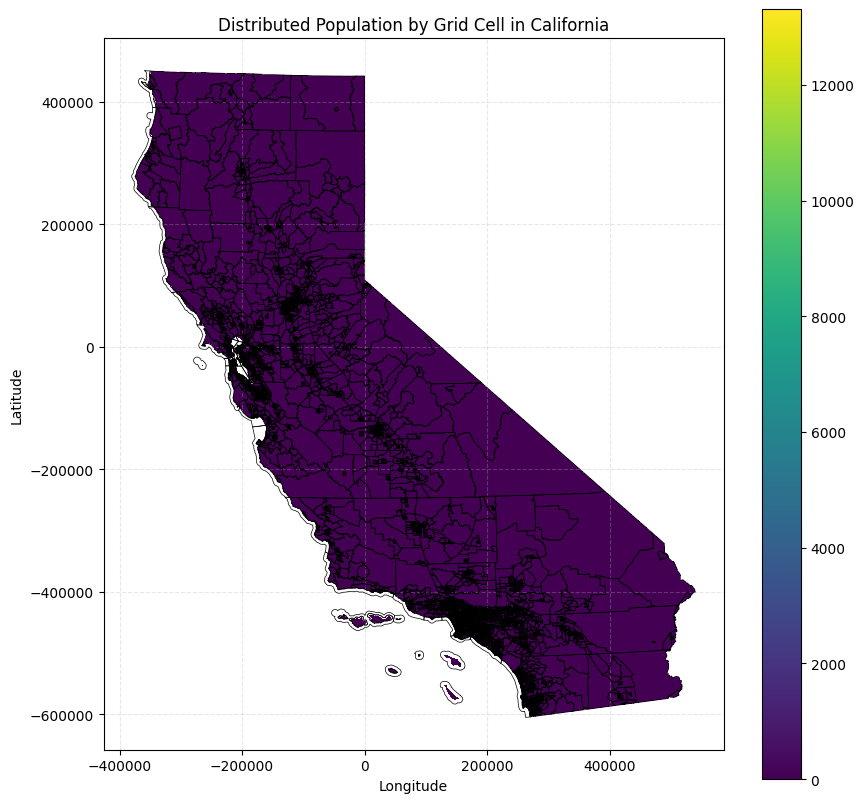

In [181]:
# Plotting the distributed population
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# Plot the grid cells with population
polygons_gdf.plot(column='cell_population', ax=ax, legend=True,
                   cmap='viridis' )
# Plot the original tracts for reference
california_gdf.boundary.plot(ax=ax, linewidth=0.5, color='black')
plt.title('Distributed Population by Grid Cell in California')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()
